### Imports

In [20]:
import pandas as pd
from pymongo import MongoClient
from bson.objectid import ObjectId
import datetime
from time import time
import pprint
import pymongo
import matplotlib.pyplot as plt
import numpy as np

### Connect to the DB

In [2]:
# connection to the database
client = MongoClient()

db_name = "PoliceShootings"

db = client[db_name]

# Get PoliceKillings collection
killings_col = db.PoliceKillings

## Simple Queries

#### Simple Query 1 - Unarmed Males under 18 killed by Police

In [3]:
simple_query_1 = { 
    'age': { '$lt': 18 }, 
    'gender': 'M', 
    'armed': 'unarmed' 
}
my_result = killings_col.find(simple_query_1)
for x in my_result:
    print(f"({x['name']}, {int(x['age'])})")

(Jeremy Mardis, 6)
(Jordan Edwards, 15)
(Jose Raul Cruz, 16)
(Deven Guilford, 17)
(David Joseph, 17)
(Armando Garcia-Muro, 17)


#### Simple Query 2 - Women killed by Police while not fleeing and not armed

In [4]:
simple_query_2 = {
    'flee': 'Not fleeing',
    'gender': 'F',
    'armed': 'unarmed'
}
my_result = killings_col.find(simple_query_2)
for x in my_result:
    print(f"({x['name']}, {int(x['age'])})")

(Autumn Steele, 34)
(India Kager, 28)
(Ciara Meyer, 12)
(Alteria Woods, 21)
(Justine Damond, 40)


## Complex queries


#### Complex Query 1 - People above 20 armed with a knife shot and Tasered by police in the state of Texas

In [5]:
complex_query_1 = [
    { "$match": 
        { "$and": 
            [
                {"armed": "knife"},
                {"manner_of_death": "shot and Tasered"},
                {"age": {"$gt": 20}}
            ]
        }
    },
    {
        "$lookup":
        {
            "from": "City",       
            "localField": "city_id",  
            "foreignField": "_id", 
            "as": "c"
        },
    },
    {  
        "$unwind": 
        { "path": '$c'} 
    },
    {
        "$lookup":
        {
            "from": "State",      
            "localField": "c.state_id",   
            "foreignField": "_id",
            "as": "s"  
        }
    },
    {  
        "$unwind": 
        { "path": '$s'} 
    },
    { '$match': {'s.acronym': 'TX' } },
]

response = killings_col.aggregate(complex_query_1)

for x in response:
    print(f"({x['name']}, {x['age']}, {x['s']['acronym']}, {x['armed']})")   

(Gregory Mathis, 36.0, TX, knife)
(Randall Lance Hughes, 48.0, TX, knife)
(Rodney Henderson, 48.0, TX, knife)
(Henry Reyna, 49.0, TX, knife)
(Ray Valdez, 55.0, TX, knife)


In [6]:
state_col = db["State"]

improve_complex_query_1 = [
    { '$match': {'acronym': 'TX' } },
    {
        "$lookup":
        {
            "from": "City",       
            "localField": "_id",  
            "foreignField": "state_id", 
            "as": "c"
        },
    },
    {  
        "$unwind": 
        { "path": '$c'} 
    },
    {
        "$lookup":
        {
            "from": "PoliceKillings",      
            "localField": "c._id",   
            "foreignField": "city_id",
            "as": "p"  
        }
    },
    {  
        "$unwind": 
        { "path": '$p'} 
    },
    { "$match": 
        { "$and": 
            [
                {"p.armed": "knife"},
                {"p.manner_of_death": "shot and Tasered"},
                {"p.age": {"$gt": 20}}
            ]
        }
    },
]

response = state_col.aggregate(improve_complex_query_1)

for x in response:
        print(f"({x['p']['name']}, {x['p']['age']}, {x['acronym']}, {x['p']['armed']})")   

(Henry Reyna, 49.0, TX, knife)
(Rodney Henderson, 48.0, TX, knife)
(Ray Valdez, 55.0, TX, knife)
(Randall Lance Hughes, 48.0, TX, knife)
(Gregory Mathis, 36.0, TX, knife)


### Complex Query 2 - State with the most shootings against males under the age of 18

In [7]:
complex_query_2 = [
  { "$match": 
        { "$and": 
            [
                {"gender": "M"},
                {"age": {"$lt": 18}}
            ]
        }
    },
  {
      "$lookup":
      {
          "from": "City",       
          "localField": "city_id",  
          "foreignField": "_id", 
          "as": "c"
      },
  },
  {  
      "$unwind": 
      { "path": '$c'} 
  },
  {
      "$lookup":
      {
          "from": "State",      
          "localField": "c.state_id",   
          "foreignField": "_id",
          "as": "s"  
      }
  },
  {  
      "$unwind": 
      { "path": '$s'} 
  },
  { "$group": { "_id": "$s.acronym", "shootings": { "$sum": 1 } } },
  { "$sort": { "shootings": -1 } },
  { "$limit": 1}
]

response = killings_col.aggregate(complex_query_2)

for x in response:
    print(x) 

{'_id': 'CA', 'shootings': 11}


### Insert Quert - Insert new police killing

In [8]:
mydict = {
    "name": "John Smith", 
    "date": datetime.datetime(2020, 2, 25), 
    "manner_of_death": "shot", 
    "armed": "toy weapon", 
    "age": 34,
    "gender": "M", 
    "race_id": ObjectId("63726502634ca21d0f760540"), 
    "city_id": ObjectId("637264fd634ca21d0f75927c"), 
    "signs_of_mental_illness": True, 
    "threat_level": "attack", 
    "flee": None, 
    "body_camera": True 
}

insertion_result = killings_col.insert_one(mydict)

### Update Query - Update the date of the police killing

In [9]:
new_date = datetime.datetime(2022, 2, 25)

killings_col.update_one(
    {"_id": insertion_result.inserted_id},
    {"$set": {"date": new_date}}
)

## Index

In [10]:
# Number of iterations used in performance
iterations = 20

# Get average performance
def performance(collection, query, is_aggregate):
    result = 0
    for _ in range(iterations):
        time_i = time()
        if is_aggregate:
            collection.aggregate(query)
        else:
            collection.find(query)
        time_f = time()
        result += time_f-time_i
    return result / iterations

# Get performance for all queries
def performance_list():
    return {
        "simple_query_1" : performance(killings_col, simple_query_1, False),
        "simple_query_2" : performance(killings_col, simple_query_2, False),
        "complex_query_1" : performance(killings_col, improve_complex_query_1, True),
        "complex_query_2" : performance(killings_col, complex_query_2, True)
    }

In [11]:
# Get examined doc num for all queries
def examined_list():
    return {
        "simple_query_1": killings_col.find(simple_query_1).explain()["executionStats"]["totalDocsExamined"],
        "simple_query_2": killings_col.find(simple_query_2).explain()["executionStats"]["totalDocsExamined"],
    }

### Performance without indexes

In [12]:
city_col = db["City"]
state_col = db["State"]

# Drop pre-existing indexes
killings_col.drop_indexes()
city_col.drop_indexes()

In [13]:
# Simple query 1 - 2541 docs examined
# Simple query 2 - 2539 docs examined

performance_no_index = performance_list()

In [14]:
examined_no_index = examined_list()

### Add indexes

In [15]:
# For simple_query 1
killings_col.create_index(
    [
        ("gender", pymongo.ASCENDING),
        ("armed", pymongo.ASCENDING),
        ("age", pymongo.ASCENDING)
    ],
    name="simple_query_1_index"
)

# For simple_query 2
killings_col.create_index(
    [
        ("gender", pymongo.ASCENDING),
        ("armed", pymongo.ASCENDING),
        ("flee", pymongo.ASCENDING)
    ],
    name="simple_query_2_index"
)

# For complex_query 1
killings_col.create_index(
    [
        ("armed", pymongo.ASCENDING),
        ("manner_of_death", pymongo.ASCENDING),
        ("age", pymongo.ASCENDING),
    ],
    name="complex_query_1_index"
)

# For complex_query 1
killings_col.create_index(
    [
        ("city_id", pymongo.ASCENDING),
    ],
    name="complex_query_1_1_index"
)

# For complex_query 1
city_col.create_index(
    [
        ("state_id", pymongo.ASCENDING),
    ],
    name="complex_query_1_index"
)

# For complex_query 1
killings_col.create_index(
    [
        ("gender", pymongo.ASCENDING),
        ("age", pymongo.ASCENDING),
    ],
    name="complex_query_2_index"
)


# city_col.create_index(
#     [
#         ("_id", pymongo.ASCENDING),
#         ("city_id", pymongo.ASCENDING),
#     ],
#     name="simple_query_3_index"
# )

# state_col.create_index(
#     [
#         ("_id", pymongo.ASCENDING),
#         ("acronym", pymongo.ASCENDING),
#     ],
#     name="simple_query_3_index"
# )

'complex_query_2_index'

### Performance with indexes

In [16]:
# Simple query 1 - 6 docs examined
# Simple query 2 - 5 docs examined

performance_index = performance_list()

In [17]:
examined_index = examined_list()

### Performance of queries with and without indexes

In [18]:
print('Times without indexes:')
pprint.pprint(performance_no_index)

print('\nTimes with indexes:')
pprint.pprint(performance_index)

print('\nExamined documents with indexes:')
pprint.pprint(examined_no_index)

print('\nExamined documents without indexes:')
pprint.pprint(examined_index)

Times without indexes:
{'complex_query_1': 0.04702627658843994,
 'complex_query_2': 0.051792144775390625,
 'simple_query_1': 9.47713851928711e-06,
 'simple_query_2': 7.87973403930664e-06}

Times with indexes:
{'complex_query_1': 0.04288694858551025,
 'complex_query_2': 0.050462758541107176,
 'simple_query_1': 5.829334259033203e-06,
 'simple_query_2': 4.339218139648437e-06}

Examined documents with indexes:
{'simple_query_1': 2537, 'simple_query_2': 2537}

Examined documents without indexes:
{'simple_query_1': 6, 'simple_query_2': 5}


### Generate Plot

#### Simple Queries

[9.47713851928711e-06, 7.87973403930664e-06]


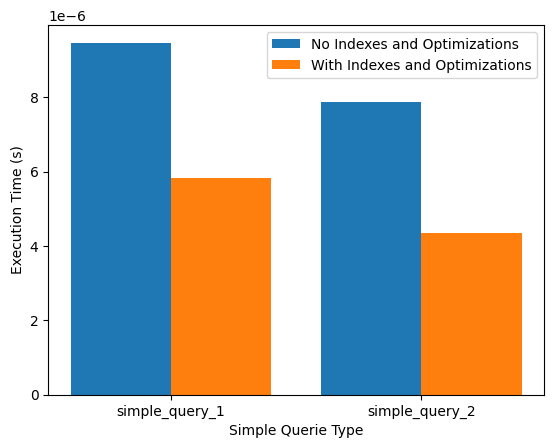

In [28]:
X_axis = np.arange(2)

plt.bar(X_axis - 0.2, list(performance_no_index.values())[0:2], 0.4, label="No Indexes and Optimizations")
plt.bar(X_axis + 0.2, list(performance_index.values())[0:2], 0.4, label="With Indexes and Optimizations")
plt.xticks(X_axis, list(performance_no_index.keys())[0:2])
plt.legend()
plt.xlabel("Simple Querie Type")
plt.ylabel("Execution Time (s)")
plt.show()

#### Complex Queries

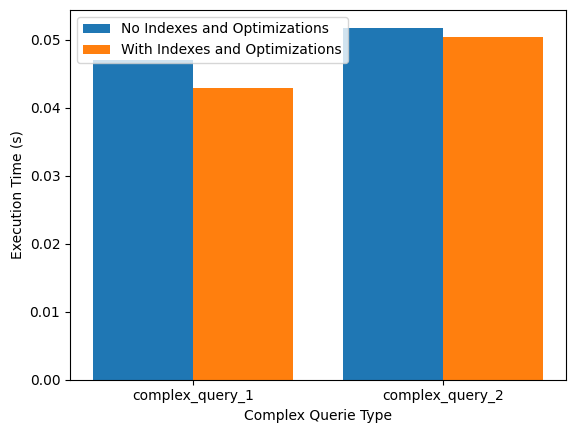

In [33]:
X_axis = np.arange(2)

plt.bar(X_axis - 0.2, list(performance_no_index.values())[2:4], 0.4, label="No Indexes and Optimizations")
plt.bar(X_axis + 0.2, list(performance_index.values())[2:4], 0.4, label="With Indexes and Optimizations")
plt.xticks(X_axis, list(performance_no_index.keys())[2:4])
plt.legend(loc="upper left")
plt.xlabel("Complex Querie Type")
plt.ylabel("Execution Time (s)")
plt.show()

### Close Connection

In [ ]:
client.close()